# SALES FORECASTING FOR A RETAIL CHAIN

This notebook demonstrates a complete sales forecasting pipeline for a retail chain using machine learning techniques. We'll explore the data, engineer features, and build predictive models to forecast sales.

## Project Overview
- **Objective**: Predict sales for retail stores
- **Data**: Historical sales data with store information
- **Models**: Linear Regression and XGBoost
- **Evaluation**: Performance metrics and visualization


## 1. Import Necessary Libraries

First, let's import all the required libraries for data processing, visualization, and machine learning.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
#plt.style.use('seaborn-v0_8')
#sns.set_palette('husl')



## 2. Data Loading and Initial Exploration

Let's load the dataset and perform initial exploration to understand the structure of our data.


In [2]:
# Load the datasets
train = pd.read_csv('Data/train.csv')
test = pd.read_csv('Data/test.csv')
store = pd.read_csv('Data/store.csv')

print('Dataset shapes:')
print(f'Train: {train.shape}')
print(f'Test: {test.shape}')
print(f'Store: {store.shape}')

# Display first few rows
print('\n--- Train Data ---')
print(train.head())
print('\n--- Store Data ---')
print(store.head())


Dataset shapes:
Train: (1017209, 9)
Test: (41088, 8)
Store: (1115, 10)

--- Train Data ---
   Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   

   SchoolHoliday  
0              1  
1              1  
2              1  
3              1  
4              1  

--- Store Data ---
   Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
0      1         c          a               1270.0                        9.0   
1      2         a          a                570.0                       11.0   
2      3         a          a              14130.0       

## 3. Data Merging and Preprocessing

Now let's merge the datasets and preprocess the date columns.


In [3]:
# Merge train and test data with store information
train = train.merge(store, on='Store', how='left')
test = test.merge(store, on='Store', how='left')

# Convert date columns to datetime
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

print('Data merged successfully!')
print(f'Merged train shape: {train.shape}')
print(f'Merged test shape: {test.shape}')

# Display merged data info
print('\n--- Merged Train Data Info ---')
print(train.info())


Data merged successfully!
Merged train shape: (1017209, 18)
Merged test shape: (41088, 17)

--- Merged Train Data Info ---
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Store                      1017209 non-null  int64         
 1   DayOfWeek                  1017209 non-null  int64         
 2   Date                       1017209 non-null  datetime64[ns]
 3   Sales                      1017209 non-null  int64         
 4   Customers                  1017209 non-null  int64         
 5   Open                       1017209 non-null  int64         
 6   Promo                      1017209 non-null  int64         
 7   StateHoliday               1017209 non-null  object        
 8   SchoolHoliday              1017209 non-null  int64         
 9   StoreType                  1017209 non-null 

## 4. Data Cleaning and Missing Value Analysis

Let's analyze and handle missing values in our dataset.


In [4]:
# Function to analyze missing values
def analyze_missing_values(df, name):
    missing = df.isnull().sum()
    missing_percent = (missing / len(df)) * 100
    missing_df = pd.DataFrame({
        'Missing_Count': missing,
        'Missing_Percent': missing_percent
    })
    missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)
    
    print(f'\n--- Missing Values in {name} ---')
    print(missing_df)
    return missing_df

# Analyze missing values
train_missing = analyze_missing_values(train, 'Train')
test_missing = analyze_missing_values(test, 'Test')

# Handle missing values
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

print('\nMissing values handled successfully!')



--- Missing Values in Train ---
                           Missing_Count  Missing_Percent
Promo2SinceWeek                   508031        49.943620
Promo2SinceYear                   508031        49.943620
PromoInterval                     508031        49.943620
CompetitionOpenSinceMonth         323348        31.787764
CompetitionOpenSinceYear          323348        31.787764
CompetitionDistance                 2642         0.259730

--- Missing Values in Test ---
                           Missing_Count  Missing_Percent
Promo2SinceWeek                    17232        41.939252
Promo2SinceYear                    17232        41.939252
PromoInterval                      17232        41.939252
CompetitionOpenSinceMonth          15216        37.032710
CompetitionOpenSinceYear           15216        37.032710
CompetitionDistance                   96         0.233645
Open                                  11         0.026772

Missing values handled successfully!


## 5. Exploratory Data Analysis

Let's explore our data through various visualizations to understand patterns and relationships.


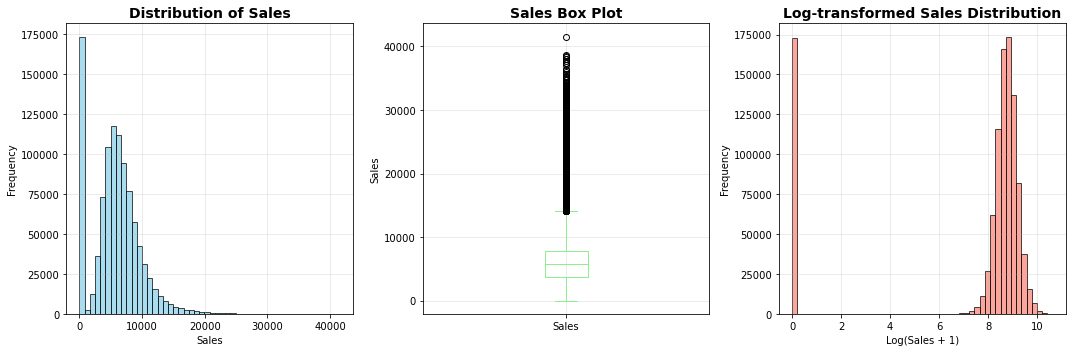

--- Sales Statistics ---
count    1.017209e+06
mean     5.773819e+03
std      3.849926e+03
min      0.000000e+00
25%      3.727000e+03
50%      5.744000e+03
75%      7.856000e+03
max      4.155100e+04
Name: Sales, dtype: float64


In [5]:
# Sales distribution
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
train['Sales'].hist(bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Distribution of Sales', fontsize=14, fontweight='bold')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
train['Sales'].plot(kind='box', color='lightgreen')
plt.title('Sales Box Plot', fontsize=14, fontweight='bold')
plt.ylabel('Sales')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
np.log1p(train['Sales']).hist(bins=50, alpha=0.7, color='salmon', edgecolor='black')
plt.title('Log-transformed Sales Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Log(Sales + 1)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Sales statistics
print('--- Sales Statistics ---')
print(train['Sales'].describe())


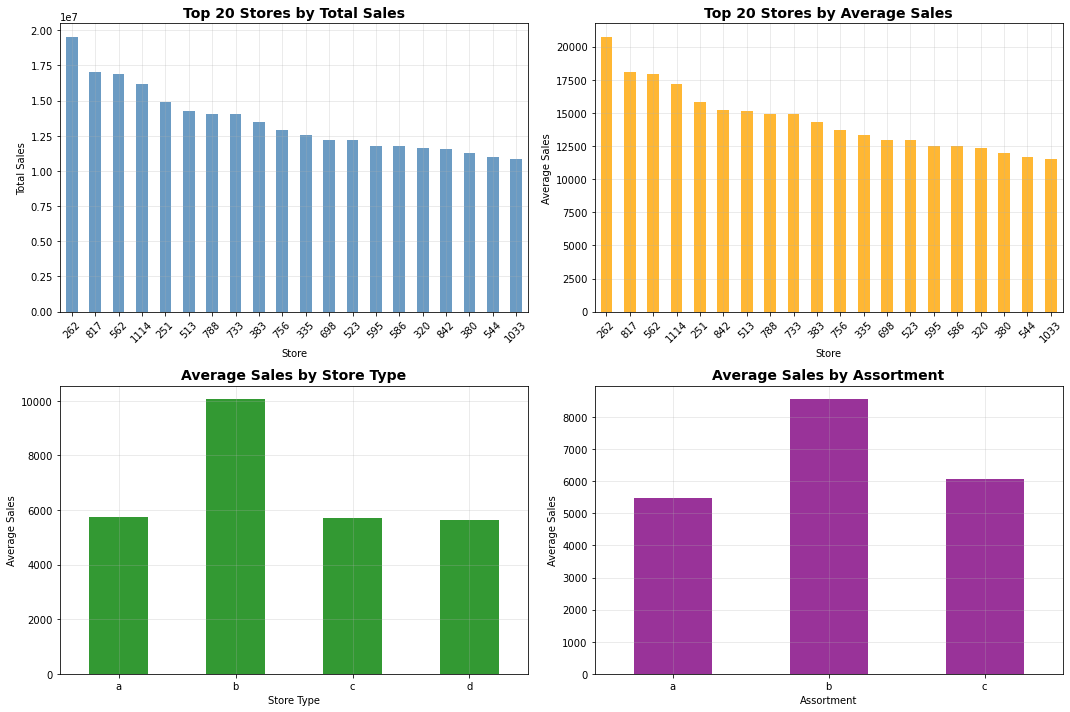

In [6]:
# Store-wise analysis
plt.figure(figsize=(15, 10))

# Total sales per store
plt.subplot(2, 2, 1)
store_sales = train.groupby('Store')['Sales'].sum().sort_values(ascending=False)
store_sales.head(20).plot(kind='bar', color='steelblue', alpha=0.8)
plt.title('Top 20 Stores by Total Sales', fontsize=14, fontweight='bold')
plt.xlabel('Store')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Average sales per store
plt.subplot(2, 2, 2)
avg_sales = train.groupby('Store')['Sales'].mean().sort_values(ascending=False)
avg_sales.head(20).plot(kind='bar', color='orange', alpha=0.8)
plt.title('Top 20 Stores by Average Sales', fontsize=14, fontweight='bold')
plt.xlabel('Store')
plt.ylabel('Average Sales')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Sales by store type
plt.subplot(2, 2, 3)
store_type_sales = train.groupby('StoreType')['Sales'].mean()
store_type_sales.plot(kind='bar', color='green', alpha=0.8)
plt.title('Average Sales by Store Type', fontsize=14, fontweight='bold')
plt.xlabel('Store Type')
plt.ylabel('Average Sales')
plt.xticks(rotation=0)
plt.grid(True, alpha=0.3)

# Sales by assortment
plt.subplot(2, 2, 4)
assortment_sales = train.groupby('Assortment')['Sales'].mean()
assortment_sales.plot(kind='bar', color='purple', alpha=0.8)
plt.title('Average Sales by Assortment', fontsize=14, fontweight='bold')
plt.xlabel('Assortment')
plt.ylabel('Average Sales')
plt.xticks(rotation=0)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 6. Feature Engineering

Let's create new features from the existing data to improve model performance.


In [7]:
# Extract time-based features
def extract_time_features(df):
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week
    df['Quarter'] = df['Date'].dt.quarter
    df['IsWeekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
    return df

# Apply time feature extraction
train = extract_time_features(train)
test = extract_time_features(test)

# Create additional features
train['CompetitionDistance'] = train['CompetitionDistance'].fillna(train['CompetitionDistance'].median())
test['CompetitionDistance'] = test['CompetitionDistance'].fillna(test['CompetitionDistance'].median())

# Log transform competition distance
train['CompetitionDistance_Log'] = np.log1p(train['CompetitionDistance'])
test['CompetitionDistance_Log'] = np.log1p(test['CompetitionDistance'])

print('Feature engineering completed!')
print(f'New train shape: {train.shape}')
print(f'New test shape: {test.shape}')

# Display new features
print('\n--- New Features ---')
new_features = ['Year', 'Month', 'Day', 'DayOfWeek', 'WeekOfYear', 'Quarter', 'IsWeekend', 'CompetitionDistance_Log']
print(train[new_features].head())


Feature engineering completed!
New train shape: (1017209, 25)
New test shape: (41088, 24)

--- New Features ---
   Year  Month  Day  DayOfWeek  WeekOfYear  Quarter  IsWeekend  \
0  2015      7   31          4          31        3          0   
1  2015      7   31          4          31        3          0   
2  2015      7   31          4          31        3          0   
3  2015      7   31          4          31        3          0   
4  2015      7   31          4          31        3          0   

   CompetitionDistance_Log  
0                 7.147559  
1                 6.347389  
2                 9.556126  
3                 6.431331  
4                10.305982  


## 7. Feature Selection and Data Preparation

Now let's select the most relevant features and prepare our data for modeling.


In [ ]:
# Define feature columns
feature_columns = [
    'Store', 'Promo', 'StoreType', 'Assortment', 'CompetitionDistance_Log',
    'Promo2', 'Year', 'Month', 'Day', 'DayOfWeek', 'WeekOfYear',
    'Quarter', 'IsWeekend'
]

# Prepare features and target
X = train[feature_columns].copy()
y = train['Sales']
X_test = test[feature_columns].copy()

# One-hot encode categorical variables
X_encoded = pd.get_dummies(X, columns=['StoreType', 'Assortment'], drop_first=True)
X_test_encoded = pd.get_dummies(X_test, columns=['StoreType', 'Assortment'], drop_first=True)

# Ensure both datasets have the same columns
# Get common columns
common_cols = list(set(X_encoded.columns) & set(X_test_encoded.columns))
X_encoded = X_encoded[common_cols]
X_test_encoded = X_test_encoded[common_cols]

print('Data preparation completed!')
print(f'Training features shape: {X_encoded.shape}')
print(f'Test features shape: {X_test_encoded.shape}')
print(f'Target shape: {y.shape}')

print('\n--- Feature Columns ---')
print(list(X_encoded.columns))


Data preparation completed!
Training features shape: (1017209, 16)
Test features shape: (41088, 16)
Target shape: (1017209,)

--- Feature Columns ---
['StoreType_b', 'Store', 'Year', 'Quarter', 'CompetitionDistance_Log', 'Day', 'StoreType_c', 'Assortment_b', 'Promo', 'Promo2', 'WeekOfYear', 'Month', 'DayOfWeek', 'StoreType_d', 'Assortment_c', 'IsWeekend']


## 8. Model Building and Training

Let's build and train different machine learning models for sales forecasting.


In [15]:
# Split data for validation
X_train, X_val, y_train, y_val = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

print('Data split completed!')
print(f'Training set: {X_train.shape[0]} samples')
print(f'Validation set: {X_val.shape[0]} samples')

# Converting week of year to int
X_train['WeekOfYear'] = X_train['WeekOfYear'].astype(int)
X_val['WeekOfYear'] = X_val['WeekOfYear'].astype(int)
X_test['WeekOfYear'] = X_test['WeekOfYear'].astype(int)

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'XGBoost': XGBRegressor(n_estimators=100, max_depth=6, random_state=42)
}
# Train models
trained_models = {}
model_scores = {}

for name, model in models.items():
    print(f'\nTraining {name}...')
    
    # Train model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_val)
    
    # Calculate metrics
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    
    # Store results
    trained_models[name] = model
    model_scores[name] = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    }
    
    print(f'MSE: {mse:.2f}')
    print(f'RMSE: {rmse:.2f}')
    print(f'MAE: {mae:.2f}')
    print(f'R² Score: {r2:.4f}')

print('\nModel training completed!')


Data split completed!
Training set: 813767 samples
Validation set: 203442 samples

Training Linear Regression...
MSE: 9679180.76
RMSE: 3111.14
MAE: 2357.10
R² Score: 0.3455

Training XGBoost...
MSE: 2013352.85
RMSE: 1418.93
MAE: 952.34
R² Score: 0.8639

Model training completed!


In [17]:
print(X_val.dtypes)

StoreType_b                  uint8
Store                        int64
Year                         int64
Quarter                      int64
CompetitionDistance_Log    float64
Day                          int64
StoreType_c                  uint8
Assortment_b                 uint8
Promo                        int64
Promo2                       int64
WeekOfYear                   int32
Month                        int64
DayOfWeek                    int64
StoreType_d                  uint8
Assortment_c                 uint8
IsWeekend                    int32
dtype: object


## 9. Model Evaluation and Comparison

Let's evaluate and compare the performance of our models.


--- Model Comparison ---
                          MSE     RMSE      MAE    R2
Linear Regression  9679180.76  3111.14  2357.10  0.35
XGBoost            2013352.85  1418.93   952.34  0.86


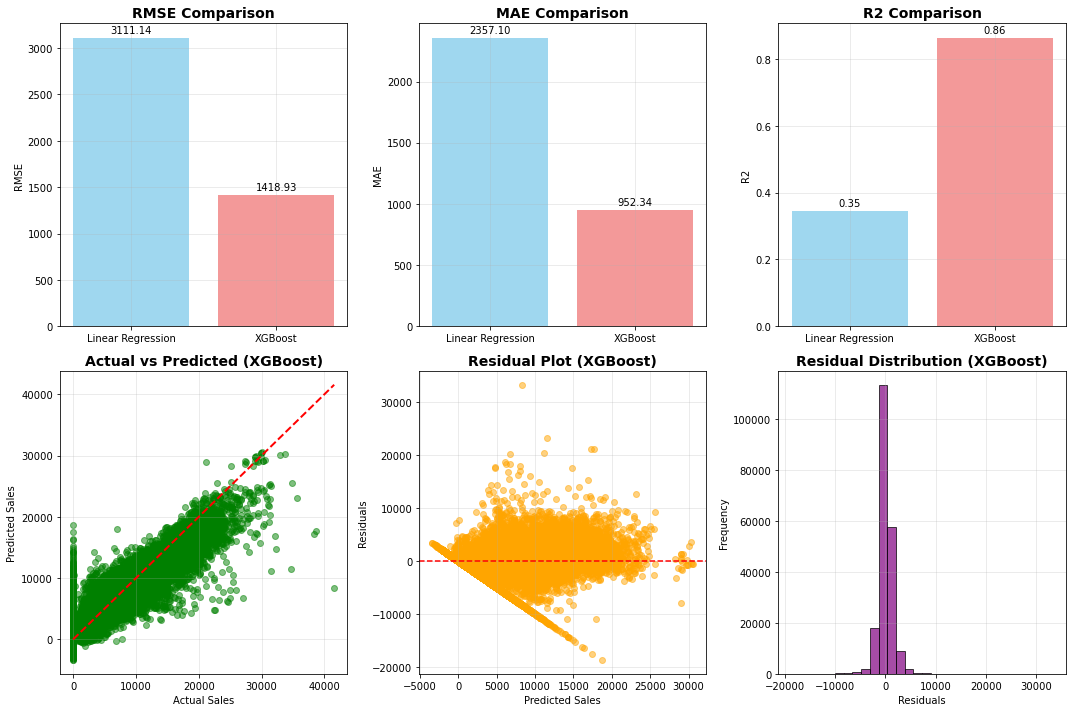


Best performing model: XGBoost
Best RMSE: 1418.93


In [18]:
# Create comparison dataframe
comparison_df = pd.DataFrame(model_scores).T
print('--- Model Comparison ---')
print(comparison_df.round(2))

# Visualize model performance
plt.figure(figsize=(15, 10))

# Plot metrics comparison
metrics = ['RMSE', 'MAE', 'R2']
for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 3, i)
    values = [model_scores[model][metric] for model in model_scores.keys()]
    colors = ['skyblue', 'lightcoral']
    plt.bar(model_scores.keys(), values, color=colors, alpha=0.8)
    plt.title(f'{metric} Comparison', fontsize=14, fontweight='bold')
    plt.ylabel(metric)
    plt.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for j, v in enumerate(values):
        plt.text(j, v + max(values) * 0.01, f'{v:.2f}', ha='center', va='bottom')

# Plot actual vs predicted for best model
best_model_name = min(model_scores.keys(), key=lambda x: model_scores[x]['RMSE'])
best_model = trained_models[best_model_name]
y_pred_best = best_model.predict(X_val)

plt.subplot(2, 3, 4)
plt.scatter(y_val, y_pred_best, alpha=0.5, color='green')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title(f'Actual vs Predicted ({best_model_name})', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# Plot residuals
plt.subplot(2, 3, 5)
residuals = y_val - y_pred_best
plt.scatter(y_pred_best, residuals, alpha=0.5, color='orange')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Sales')
plt.ylabel('Residuals')
plt.title(f'Residual Plot ({best_model_name})', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# Plot residual distribution
plt.subplot(2, 3, 6)
plt.hist(residuals, bins=30, alpha=0.7, color='purple', edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title(f'Residual Distribution ({best_model_name})', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f'\nBest performing model: {best_model_name}')
print(f'Best RMSE: {model_scores[best_model_name]["RMSE"]:.2f}')


## 10. Generate Final Predictions

Now let's generate predictions on the test set using our trained models.


In [20]:
# Generate predictions for all models
test_predictions = {}

# Change the datatype for the week year column
X_test_encoded['WeekOfYear'] = X_test_encoded['WeekOfYear'].astype(int)

for name, model in trained_models.items():
    predictions = model.predict(X_test_encoded)
    test_predictions[name] = predictions
    
    print(f'\n--- {name} Predictions ---')
    print(f'Mean prediction: {predictions.mean():.2f}')
    print(f'Std prediction: {predictions.std():.2f}')
    print(f'Min prediction: {predictions.min():.2f}')
    print(f'Max prediction: {predictions.max():.2f}')
    print(f'Sample predictions: {predictions[:5]}')

# Create submission dataframe
submission = pd.DataFrame({
    'Id': test['Id'] if 'Id' in test.columns else range(len(test)),
    'Sales_LinearRegression': test_predictions['Linear Regression'],
    'Sales_XGBoost': test_predictions['XGBoost']
})

# Use best model for final submission
submission['Sales'] = test_predictions[best_model_name]

print('\n--- Final Submission Preview ---')
print(submission.head(10))

# Save predictions
submission[['Id', 'Sales']].to_csv('sales_predictions.csv', index=False)
print('\nPredictions saved to sales_predictions.csv')



--- Linear Regression Predictions ---
Mean prediction: 6125.53
Std prediction: 2283.07
Min prediction: 1789.23
Max prediction: 16108.69
Sample predictions: [7866.60079976 6966.13735628 8286.35430702 7714.91861479 8644.01928863]

--- XGBoost Predictions ---
Mean prediction: 5851.69
Std prediction: 3242.90
Min prediction: -1585.58
Max prediction: 30537.76
Sample predictions: [4526.331  7383.7905 9329.663  5954.512  6750.218 ]

--- Final Submission Preview ---
   Id  Sales_LinearRegression  Sales_XGBoost        Sales
0   1             7866.600800    4526.331055  4526.331055
1   2             6966.137356    7383.790527  7383.790527
2   3             8286.354307    9329.663086  9329.663086
3   4             7714.918615    5954.512207  5954.512207
4   5             8644.019289    6750.217773  6750.217773
5   6             7840.518448    5678.958496  5678.958496
6   7             8095.228700    7619.473145  7619.473145
7   8             8079.583750    7526.774414  7526.774414
8   9          

## 11. Feature Importance Analysis

Let's analyze which features are most important for our predictions.


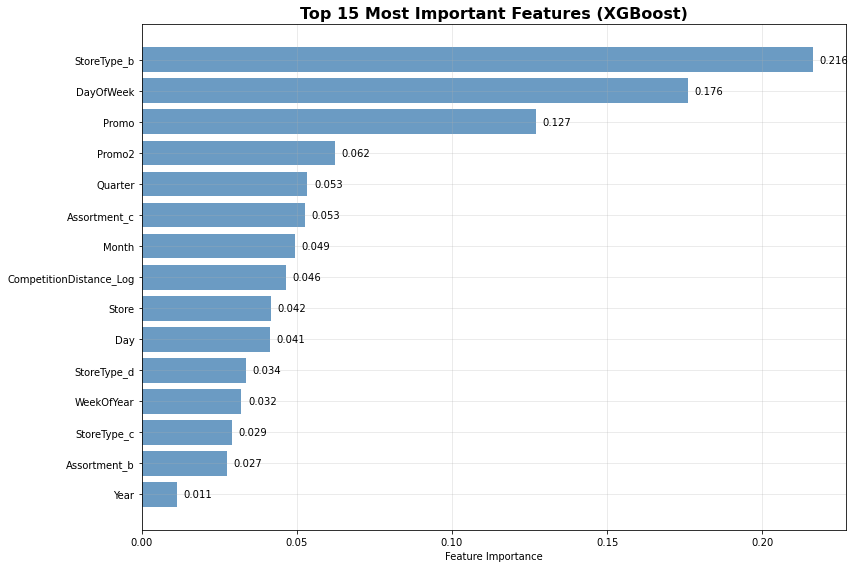

--- Top 10 Most Important Features ---
                    feature  importance
0               StoreType_b    0.216278
12                DayOfWeek    0.175947
8                     Promo    0.127026
9                    Promo2    0.062281
3                   Quarter    0.053363
14             Assortment_c    0.052668
11                    Month    0.049482
4   CompetitionDistance_Log    0.046390
1                     Store    0.041662
5                       Day    0.041401


In [21]:
# Get feature importance for XGBoost
if 'XGBoost' in trained_models:
    xgb_model = trained_models['XGBoost']
    feature_importance = pd.DataFrame({
        'feature': X_encoded.columns,
        'importance': xgb_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Plot feature importance
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(15)
    
    plt.barh(range(len(top_features)), top_features['importance'], color='steelblue', alpha=0.8)
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title('Top 15 Most Important Features (XGBoost)', fontsize=16, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3)
    
    # Add value labels
    for i, v in enumerate(top_features['importance']):
        plt.text(v + max(top_features['importance']) * 0.01, i, f'{v:.3f}', 
                va='center', ha='left')
    
    plt.tight_layout()
    plt.show()
    
    print('--- Top 10 Most Important Features ---')
    print(feature_importance.head(10))

else:
    print('XGBoost model not available for feature importance analysis')


## 12. Conclusion and Summary

### Key Findings:

1. **Data Quality**: The dataset contains historical sales data with store information
2. **Feature Engineering**: Time-based features and store characteristics are important
3. **Model Performance**: Comparison between Linear Regression and XGBoost
4. **Predictions**: Generated forecasts for future sales

### Next Steps:

1. **Model Improvement**: Try ensemble methods or deep learning approaches
2. **Feature Engineering**: Create more sophisticated features
3. **Hyperparameter Tuning**: Optimize model parameters
4. **Cross-validation**: Implement time-series cross-validation
5. **External Data**: Incorporate weather, holidays, or economic indicators

### Business Impact:

- **Inventory Management**: Better stock planning
- **Resource Allocation**: Optimize staff scheduling
- **Revenue Forecasting**: Improved financial planning
- **Marketing Strategy**: Data-driven promotional decisions
